In [5]:
import numpy as np
import scipy
from scipy.ndimage import gaussian_filter1d
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp
import change_point_and_behavior as cpb

import place_field_analysis as pf
import pingouin as pg
import trial_correlates as tc

In [2]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/cosyne'

In [3]:

data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [4]:
mat_to_return=prep.load_stuff(data_dir_full)

smth_in_bin=2.5 
speed_thresh=1.
nbins=100
speed_key='v'

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df=dpp.group_into_trialtype(spk_beh_df)
cell_cols_d = prep_res['cell_cols_d']
# beh_df = prep_res['beh_df'].as_dataframe()
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']
cell_cols = cell_cols_d['pyr']
spk_beh_df,lin_bins = dpp.add_lin_binned(spk_beh_df,nbins=nbins)
# fr maps

fr_map_dict=pa.get_fr_map_trial(spk_beh_df,cell_cols,trialtype_key='trial_type',speed_thresh=speed_thresh,order=['smooth','divide'],speed_key=speed_key)
fr_map_trial_d = {k:val[0] for k,val in fr_map_dict.items()}
fr_map_d,count_d,occu_d = pf.ratemap_from_spk_beh_df_alltrialtype(spk_beh_df,cell_cols,speed_thresh=speed_thresh,nbins=nbins,smth_in_bin=smth_in_bin,speed_key=speed_key)



cant format into a dataframe
cant format into a dataframe


In [5]:
counts_l = {}
occupancy_l = {}
df = spk_beh_df
speed_key='v'
speed_thresh=1
mask = df[speed_key] > speed_thresh # by default only keep time points with speed above 5
df = df.loc[mask]
columns=cell_cols
n_lin_bins=100

# groupby trial, get histcount for each trial
for tt,val in df.groupby('trial'):
    # import pdb
    # pdb.set_trace()
    counts = val.groupby('lin_binned')[columns].sum()
    counts = counts.reindex(range(n_lin_bins)) #making sure all position bins are included!
    counts_l[tt]=counts
    occupancy = val.groupby('lin_binned').count().iloc[:,0].rename()
    occupancy = occupancy.reindex(range(n_lin_bins))
    occupancy_l[tt]=occupancy
counts_l = pd.concat(counts_l.values(),axis=1,keys=counts_l.keys()) # col multi indexed: trial, unit; index: lin_binned; 
# counts_l = counts_l.swaplevel(axis=1) # now col: unit, trial
counts_l = counts_l.fillna(0).astype(float)
occupancy_l = pd.concat(occupancy_l.values(),axis=1,keys=occupancy_l.keys()).fillna(0) # n_lin_binned x n_trials

In [6]:
ncells = len(cell_cols)
nbins = counts_l.shape[0]
counts_l_values = counts_l.values.reshape(nbins,-1,ncells) # npos x ntrials x ncells
counts_l_values = counts_l_values.swapaxes(0,-1).swapaxes(1,-1) # ncells x npos x ntrials
occupancy_l_values = occupancy_l.values #npos x ntrials
bin_columns = occupancy_l.index

saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/trial_correlates/trial_correlates_vthresh.p


In [209]:
counts_l.sum(axis=1)

lin_binned
0        0.0
1       99.0
2     2658.0
3     9366.0
4     9368.0
       ...  
95       0.0
96       0.0
97       0.0
98       0.0
99       0.0
Length: 100, dtype: float64

In [10]:
reload(pf)

<module 'place_field_analysis' from '/mnt/home/szheng/projects/util_code/place_field_analysis.py'>

In [16]:
# fr_map_null = misc.get_res(os.path.join(data_dir_full,'py_data'),'fr_map_null_trialtype_vthresh.p',False)[1]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype_vthresh.p exists; loading---


In [18]:
# reload(pf)
# pf.field_detection_by_trial(fr_map_trial_d,fr_map_null,cell_cols)

/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)
/mnt/home/szheng/projects/nmf_analysis/nmf_analysis.py:365: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(inds * mat,axis=axis) / np.sum(mat,axis=axis)


({(0,
   0.0):                                      0          1          2          3   \
                 field_index_cl                                              
  end      1.0   0                   84.0       84.0       84.0       85.0   
  presence 1.0   0                  False      False       True       True   
  start    1.0   0                   73.0       73.0       73.0       75.0   
  peak     1.0   0                     73         73         78         80   
  com      1.0   0                    NaN        NaN       78.0       79.0   
  ...                                 ...        ...        ...        ...   
  start    480.0 1                   69.0       74.0       70.0       70.0   
  peak     480.0 1                     77         80         77         88   
  com      480.0 1                   77.0       80.0       77.0       85.0   
  fr_peak  480.0 1               18.76717  27.384159  12.276241  20.757623   
  fr_mean  480.0 1               9.467057  14.78315

In [7]:
place_field_res=pf.field_detection_both_avg_trial_wrapper(data_dir_full, dosave=True,force_reload=False,nbins = 100, 
                                        save_fn = 'place_field_avg_and_trial_vthresh.p', 
                                        shuffle_fn='fr_map_null_trialtype_vthresh.p',
                                        smth_in_bin=2.5, speed_thresh=1.,speed_key='v'
                                        )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/fr_map_null_trialtype_vthresh.p exists; loading---
cant format into a dataframe
cant format into a dataframe
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---


In [8]:
import misc
res_to_save_dir = os.path.join(data_dir_full,'py_data','switch_analysis')
res_to_save_name = f'shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean.p'
res_to_save_data = misc.get_res(res_to_save_dir,res_to_save_name,False)[1]

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean.p exists; loading---


In [17]:
res_to_save_data['avg']['X'][0.3][0,0]

0         1         2         3         4         5         6   \
3   0  0.164310  0.164310  0.164310  0.164310  0.164310  0.164310  0.164310   
27  0  0.698877  0.698877  0.698877  0.698877  0.698877  0.698877  0.698877   
29  0  0.547310  0.547310  0.547310  0.547310  0.547310  0.547310  0.547310   
    1  0.659939  0.659939  0.659939  0.659939  0.659939  0.659939  0.659939   
    2  0.449236  0.449236  0.449236  0.449236  0.449236  0.449236  0.449236   
...         ...       ...       ...       ...       ...       ...       ...   
465 0  0.087545  0.087545  0.087545  0.087545  0.087545  0.087545  0.087545   
475 0  1.000000  0.394522  0.394522  0.394522  0.394522  0.394522  0.394522   
476 0  1.000000  0.065247  0.065247  0.065247  0.065247  0.065247  0.065247   
    1  0.133297  0.133297  0.133297  0.133297  0.133297  0.133297  0.133297   
480 0  0.378014  0.378014  0.378014  0.378014  0.378014  0.378014  0.378014   

             7         8         9   ...        23        24        25  \
3   0  0.164310  0.164310  0.164310  ...  0.631949  0.631949  0.631949   
27  0  0.698877  0.698877  0.698877  ...  0.698877  0.698877  0.698877   
29  0  0.547310  0.547310  0.547310  ...  0.133058  0.133058  0.133058   
    1  0.659939  0.659939  0.659939  ...  0.659939  0.659939  0.659939   
    2  0.449236  0.449236  0.677046  ...  0.677046  0.677046  0.677046   
...         ...       ...       ...  ...       ...       ...       ...   
465 0  0.087545  0.087545  0.087545  ...  0.073030  0.073030  0.073030   
475 0  0.110648  0.110648  0.110648  ...  0.110648  0.110648  0.110648   
476 0  0.065247  0.065247  0.065247  ...  0.065247  0.065247  0.065247   
    1  0.133297  0.133297  1.000000  ...  0.093498  0.093498  0.093498   
480 0  0.378014  0.378014  0.378014  ...  0.684328  0.684328  0.684328   

             26        27        28        29        30        31        32  
3   0  0.631949  0.631949  0.631949  0.631949  0.631949  0.631949  0.631949  
27  0  0.698877  0.698877  0.698877  0.698877  0.698877  0.698877  0.698877  
29  0  0.133058  0.133058  0.133058  0.133058  0.133058  0.133058  0.133058  
    1  0.659939  0.659939  0.659939  0.659939  0.659939  0.659939  0.659939  
    2  0.677046  0.677046  0.331625  0.331625  0.331625  0.331625  0.331625  
...         ...       ...       ...       ...       ...       ...       ...  
465 0  0.073030  0.073030  0.073030  0.073030  0.073030  0.073030  0.073030  
475 0  0.110648  0.110648  0.110648  0.110648  0.110648  0.110648  0.110648  
476 0  0.065247  0.065247  0.065247  0.065247  0.065247  0.065247  0.065247  
    1  0.093498  0.093498  0.093498  0.093498  0.093498  0.093498  0.093498  
480 0  0.684328  0.684328  0.684328  0.684328  0.684328  0.684328  0.684328  

[378 rows x 33 columns]

In [206]:
reload(tc)
trial_cor = tc.get_trial_correlates(spk_beh_df,mat_to_return,cell_cols_d,cols=None)

In [53]:
reload(tc)
speed_by_trial_pos=tc.get_speed_by_trial_pos(spk_beh_df,trial_type_key='trial_type',speed_thresh=1,speed_key='v')




In [170]:
# X = place_field_res['avg']['params'][0,0].loc['fr_mean']
X = place_field_res['trial']['params'][0,0].loc['fr_mean']

all_fields_trial = place_field_res['trial']['params'][0,0].loc[['start','end','peak']]
all_fields_trial = all_fields_trial.stack().unstack(level=0)

# all_fields=place_field_res['avg']['all_fields'][0,0]
covar_by_trial_pos = speed_by_trial_pos.loc[0,0]

In [147]:
%%time
reload(tc)
reload(cpb)
detection = 'trial_filter'
iscommonfield = False if 'trial' in detection else True
trial_type = (0,0)
covar_by_trial_pos = speed_by_trial_pos.loc[trial_type]
resid_res = cpb.get_resid_onetrialtype(place_field_res,detection,trial_type,covar_by_trial_pos,iscommonfield=iscommonfield,fr_key='fr_mean',covar_key='mean',do_renormalize=True)



CPU times: user 32.6 s, sys: 154 ms, total: 32.8 s
Wall time: 32.5 s


In [156]:
place_field_res

{'avg': {'params': {(0,
    0.0):                       0          1          2          3          4   \
   fr_mean 3   0   0.361854   1.660383   0.895757   0.000000   0.469987   
           27  0  14.423230  13.955614  23.307238  20.632551  24.110986   
           29  0   5.357048   8.640619  11.218283   9.660357   6.298226   
               1   9.346967   7.827861  16.289806  15.501734   6.856234   
               2   3.571470  17.356635  13.154855   7.584357   9.771180   
   ...                  ...        ...        ...        ...        ...   
   std     463 0   0.532035        NaN   1.159773        NaN        NaN   
           465 0   0.000000   2.465857        NaN   2.361952        NaN   
           475 0   3.352249   2.988355   3.182268   2.981122   2.891080   
           476 0   2.050810   2.445631   2.487639   2.899385   2.937413   
           480 0   3.169987   3.017373   3.525848   4.969031   3.791196   
   
                         5          6          7          8      

In [158]:
covar_by_trial_pos

    lin_binned
0   1             1.664880
    2             1.664880
    3             1.664880
    4             2.061473
    5             4.323176
                    ...   
32  88            1.025881
    89            2.447047
    90            3.868213
    91            5.692144
    92            7.516075
Length: 3036, dtype: float64

In [174]:
%%time
reload(cpb)
speed_by_trial_pos=tc.get_speed_by_trial_pos(spk_beh_df,trial_type_key='trial_type',speed_thresh=1,speed_key='v')
resid_res_d = {}
# for detection in place_field_res.keys():
for detection in ['avg','trial_filter']:
    iscommonfield = False if 'trial' in detection else True
    resid_res_d[detection] = {}
    for trial_type in place_field_res[detection]['params'].keys():
        covar_by_trial_pos = speed_by_trial_pos.loc[trial_type]
        resid_res = cpb.get_resid_onetrialtype(place_field_res,detection,trial_type,covar_by_trial_pos,iscommonfield=iscommonfield,fr_key='fr_mean',covar_key='mean',do_renormalize=True)
        resid_res_d[detection][trial_type] = resid_res
        
    
    

CPU times: user 1min 43s, sys: 634 ms, total: 1min 43s
Wall time: 1min 42s


In [194]:
resid_res[0,0]['resid']

0         1         2         3         4         5         6   \
3   0  0.188739  0.549517  0.345796  0.097913  0.203381  0.070173  0.027796   
27  0  0.000772  0.000000  0.458536  0.375160  0.534795  0.178326  0.610843   
29  0  0.330685  0.457325  0.609031  0.525087  0.356714  0.852570  0.508130   
    1  0.202999  0.068352  0.709849  0.669781  0.000000  0.377863  0.269418   
    2  0.000000  0.909846  0.580470  0.360306  0.397967  0.207999  0.294959   
...         ...       ...       ...       ...       ...       ...       ...   
463 0  0.002956  0.000000  0.129773  0.002392  0.005246  0.012826  0.264604   
465 0  0.068412  0.253760  0.042792  0.168995  0.057267  0.115536  0.343404   
475 0  1.000000  0.589759  0.467198  0.455806  0.373090  0.415517  0.427372   
476 0  1.000000  0.307563  0.167968  0.229307  0.136767  0.658103  0.483099   
480 0  0.432983  0.673238  0.240210  0.540106  0.252936  0.595399  0.256003   

             7         8         9   ...        23        24        25  \
3   0  0.144860  0.115708  0.236073  ...  0.360528  0.401058  0.401002   
27  0  0.265345  0.134671  0.141111  ...  0.268781  0.576873  0.462250   
29  0  0.573323  0.653588  0.468947  ...  0.338677  0.106111  0.158212   
    1  0.399484  0.444996  0.368674  ...  0.798425  0.753538  0.865548   
    2  0.082775  0.194584  0.715906  ...  0.727148  0.662262  0.540673   
...         ...       ...       ...  ...       ...       ...       ...   
463 0  0.001475  1.000000  0.414135  ...  0.008209  0.350274  0.012764   
465 0  0.074560  0.341286  0.133598  ...  0.221247  0.025112  0.098664   
475 0  0.152864  0.216520  0.424896  ...  0.279784  0.103390  0.294676   
476 0  0.104857  0.182651  0.428002  ...  0.021361  0.000000  0.099388   
480 0  0.308386  0.184573  0.503670  ...  0.486299  0.906397  1.000000   

             26        27        28        29        30        31        32  
3   0  0.587718  0.564772  0.622070  0.670229  0.544205  0.338081  0.694266  
27  0  0.554533  0.171952  0.442810  1.000000  0.310595  0.275212  0.311008  
29  0  0.180225  0.320179  0.081888  0.000000  0.305283  0.129788  0.080096  
    1  0.672025  0.742269  0.345305  0.645890  0.363519  0.360757  0.527703  
    2  0.786848  0.537116  0.189478  0.188895  0.365677  0.181380  0.157175  
...         ...       ...       ...       ...       ...       ...       ...  
463 0  0.020455  0.300921  0.235387  0.115915  0.034909  0.021082  0.000135  
465 0  0.048909  0.237908  0.054280  0.124912  0.065815  0.367248  0.059054  
475 0  0.173605  0.096947  0.240864  0.161876  0.153332  0.271097  0.206181  
476 0  0.103457  0.054384  0.021466  0.000069  0.120725  0.166274  0.042223  
480 0  0.254330  0.590302  0.208079  0.867694  0.569717  0.906975  0.782361  

[381 rows x 33 columns]

In [197]:
# turn resid result to place field res
pfr_resid = {}
fr_key = 'fr_mean'
for key, resid_res in resid_res_d.items():
    pfr_resid[key]={}
    pfr_resid[key]['params']={}
    pfr_resid[key]['params'] = {k:pd.concat({fr_key:resid_res[k]['resid']}) for k in resid_res.keys()}

In [201]:
import switch_analysis_one_session as saos
reload(saos)

67 sessions!


<module 'switch_analysis_one_session' from '/mnt/home/szheng/projects/nmf_analysis/scripts/switch_analysis_one_session.py'>

INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
INFO: Pandarallel will run on 28 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.

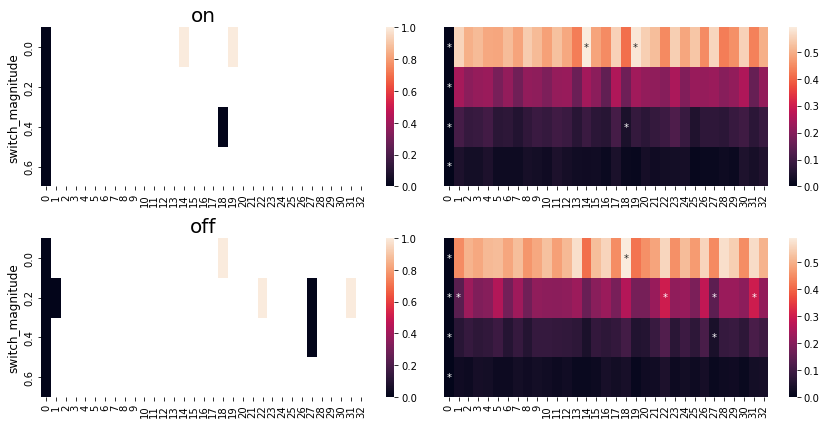

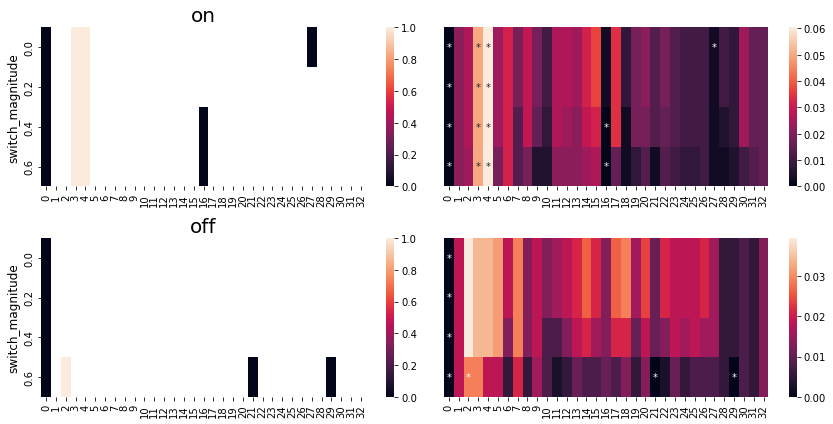

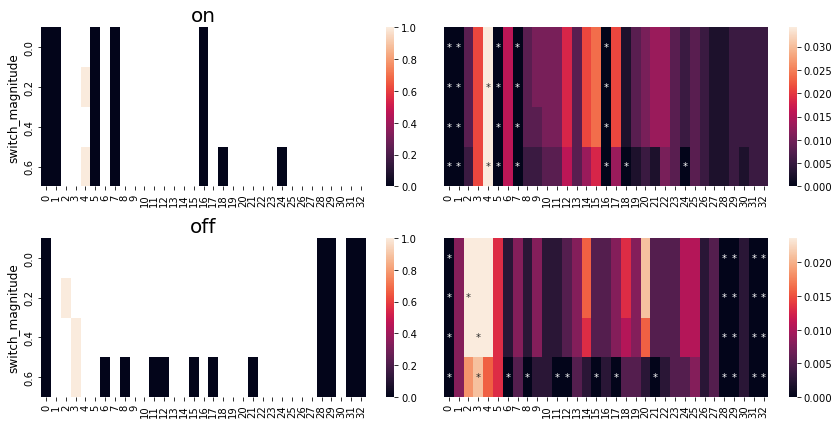

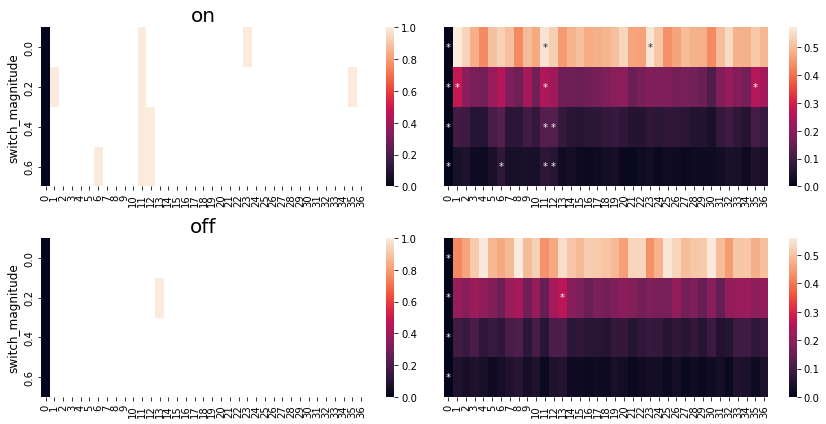

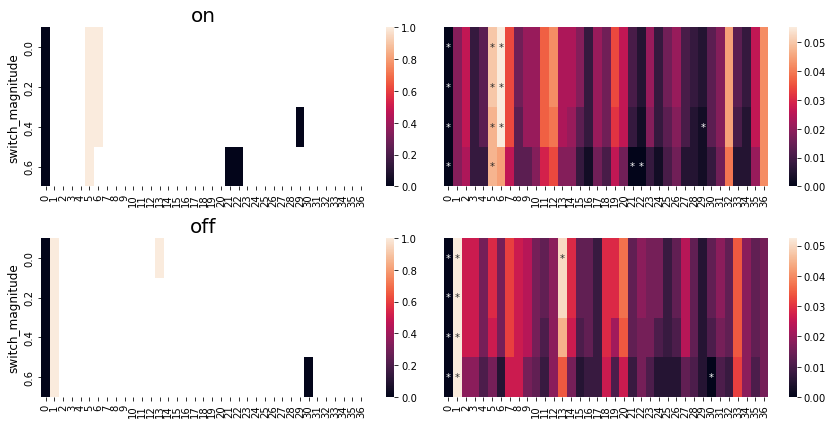

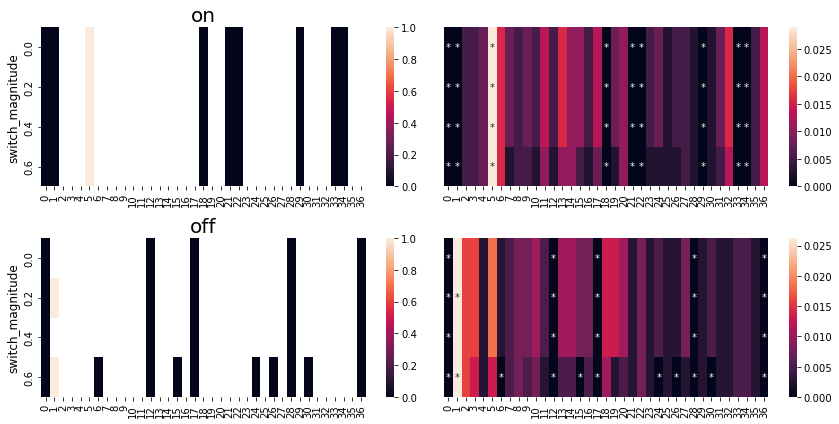

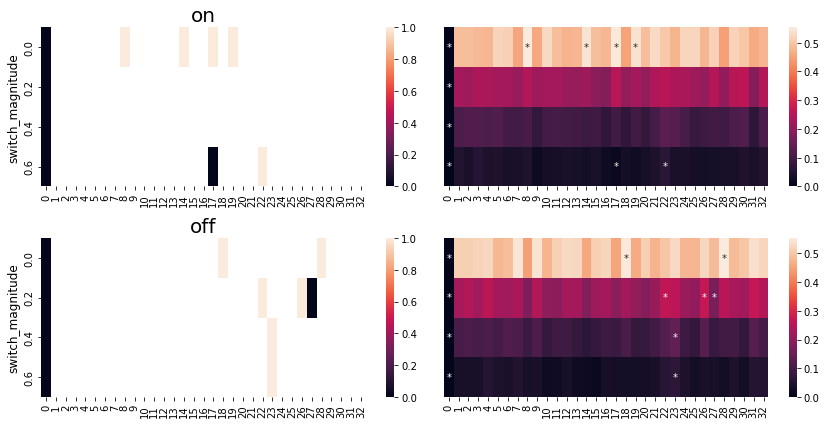

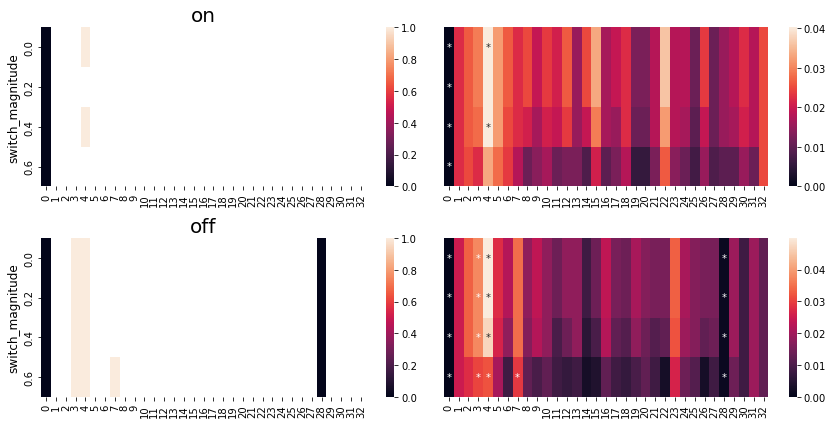

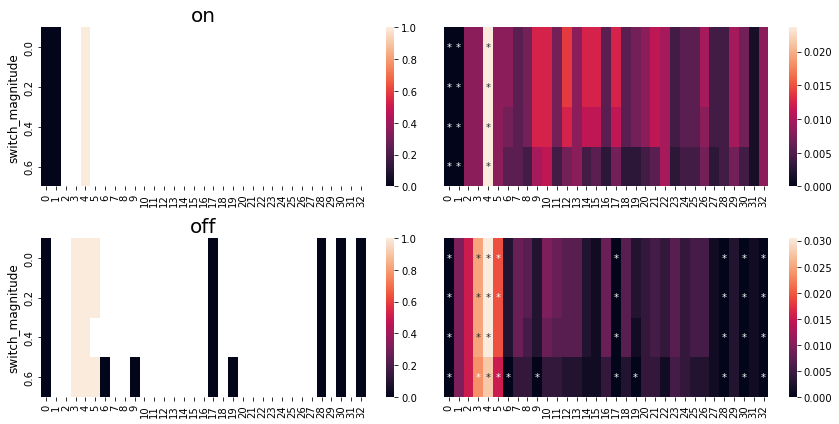

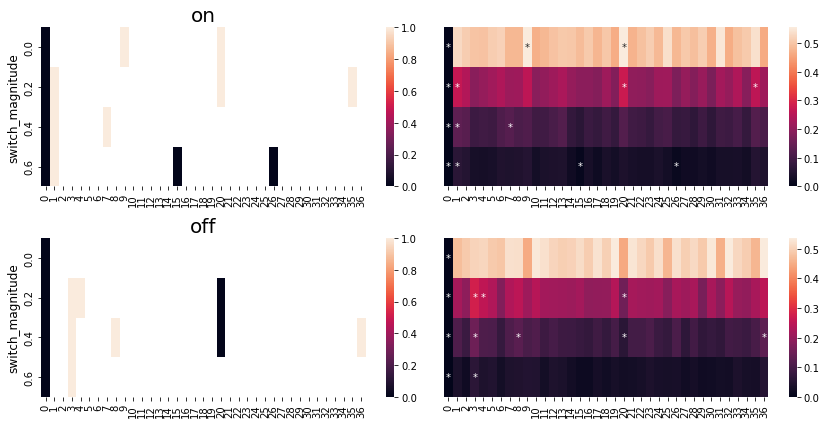

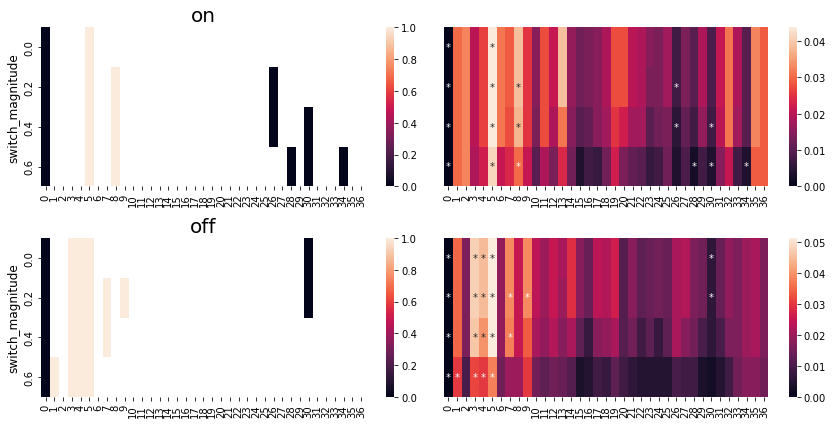

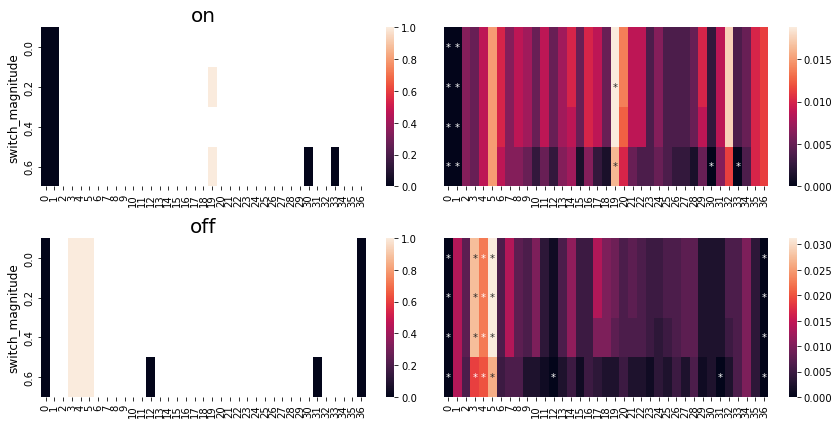

In [202]:
res_to_save_data_detection = saos.switch_analysis_one_session(data_dir_full,place_field_res=pfr_resid,dosave=True,save_fn='shuffle_detection_vthresh_switch_res_switch_magnitude_only_fr_mean_resid_v_mean.p')
    

In [159]:
reload(cpb)

<module 'change_point_and_behavior' from '/mnt/home/szheng/projects/nmf_analysis/change_point_and_behavior.py'>

<AxesSubplot:>

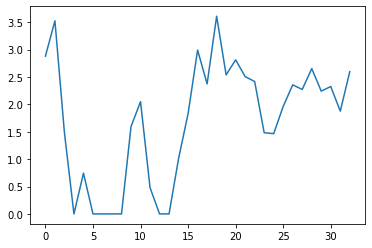

In [153]:
X.iloc[0].plot()

<AxesSubplot:>

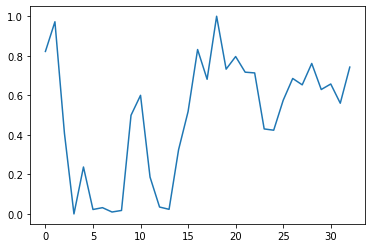

In [152]:
resid_res['resid'].iloc[0].plot()

In [171]:
%%time
reload(tc)
res_l_trial = tc.get_covar_within_field_by_trial_seperatefield(all_fields_trial,covar_by_trial_pos)

CPU times: user 1min 4s, sys: 8.9 ms, total: 1min 4s
Wall time: 1min 4s


In [172]:
res_l_trial.loc['mean'].T

1.0        3.0        27.0                                    \
            0          0          0          1          2          3   
0   28.972986  32.784936  39.746955  49.285869  15.569993  17.353833   
1   25.008586  43.358901  16.026620  46.386921  18.854017  15.099158   
2   32.124781  44.454653  24.686206  44.826967  22.621356  12.439671   
3   11.954436  44.857935  31.845809  47.071889  21.632758  10.868269   
4   26.705948  32.074944  12.955641  46.305863  18.801168  10.087614   
5   28.507694  36.125883  21.738088  43.549196  26.515351  13.025217   
6   18.556813  32.511614  35.741817  41.987747  28.092639  11.286871   
7   16.954086  41.086587  20.785144  48.386945  31.668874  13.216935   
8   23.448569  38.034793  13.330265  48.697982  24.469857   5.076813   
9   18.759149  20.992790  36.651641  25.775936  10.239754   8.995963   
10  10.710447  30.414738  18.668527  29.534508  22.267367  10.993663   
11  16.475955  23.560762  13.542161  30.294359   6.864792  12.861903   
12  24.337443  31.272153  27.222595  39.215059  16.361600   9.936696   
13  18.256050  35.774710  30.116981  42.543017  24.183787   9.600268   
14  20.059032  26.568955  24.405602  40.232450  11.605703  10.298382   
15  29.169046  39.050234  19.650952  42.642330  28.482222  11.155484   
16  23.195269  40.928181  28.348605  45.966144   6.891549   5.045450   
17   8.442954  33.424298  16.610882  38.451331  25.185067  17.572558   
18  18.021687  41.445106  31.441552  43.824868  34.102508  15.156123   
19  13.408194  31.192308  28.681068  43.694139  16.013101   5.537771   
20  20.551303  35.715834  26.909918  46.773776  29.354883  11.739471   
21  24.296094  33.736263  16.697551  34.050136  26.377648  11.491478   
22  22.977562  25.555813  10.752316  31.931873  21.066630  13.034039   
23  23.975807  35.995706  18.272565  44.159693  27.791554  12.055355   
24  12.483820  36.625419  15.641560  44.188099  29.034135   6.280886   
25  11.514792  30.853156  18.945291  39.103849  20.603921   4.429255   
26  18.935028  30.016738  13.548475  40.942523  16.926056  10.146333   
27  18.909890  33.589939  17.533348  44.606139  20.564790  13.617146   
28  17.890479  32.118410  15.573018  44.402965  31.112177  14.027745   
29  18.948540  39.573386  24.578104  44.991842  29.157995  19.048936   
30  15.955160  37.653761  17.412537  46.859603  14.168138  13.579034   
31  12.190066  27.400218  20.578751  38.272089  11.568693  13.698719   
32   9.687295  33.365923  39.619481  41.140424  27.882746   5.559580   

                  29.0                         ...      476.0      477.0  \
            4         0          1          2  ...          3          0   
0   30.034474  4.757079  22.325791  39.951205  ...  30.769331  19.536827   
1   23.611011  5.193927  21.823466  40.563202  ...  21.945373  23.472377   
2   25.199099  4.845908  20.628753  37.406576  ...  32.006064  20.759037   
3   16.644450  6.921519  21.890744  45.196237  ...  14.103699  20.918847   
4   23.605067  9.646787  21.093127  41.756973  ...  28.517950  21.741116   
5   26.445798  9.281028  20.965576  38.983986  ...  24.957982  22.285300   
6    8.771702  8.068479  23.238403  36.802559  ...  16.538988  21.719197   
7   16.818501  4.968018  22.150077  44.098805  ...  17.307894  25.286685   
8   21.430721  3.843643  21.558772  42.733775  ...  18.719317  22.352326   
9   17.029965  4.982525  22.119659  31.060614  ...  14.486971  14.783860   
10   9.277521  3.553881  18.838799  32.299526  ...  12.419724  21.273880   
11  11.182279  4.180040  20.776357  31.991982  ...  18.329456  18.818716   
12  25.302711  4.583066  21.522158  36.686570  ...  21.950354  14.385333   
13  17.148376  5.383298  20.190871  38.068520  ...  15.292150  25.348488   
14  17.408423  5.365215  19.675800  33.730571  ...  15.648296   9.115234   
15  28.094374  4.444681  20.453090  38.423997  ...  29.460444  27.666448   
16  25.134519  3.673412  20.564469  40.720780  ...  27.708034  12.095507   
17   8.477853  4.177017  19.059703  32.3859

In [55]:
%%time
reload(tc)
res_l = tc.get_covar_within_field_by_trial_commonfield(all_fields,covar_by_trial_pos)

CPU times: user 13.9 s, sys: 377 µs, total: 13.9 s
Wall time: 13.9 s


In [190]:
# fr_map_trial_df=pf.fr_map_trial_to_df(fr_map_trial_d[0,0],cell_cols)

# %matplotlib inline
# fr_map_trial_df.loc[154][31].plot()

In [59]:
from sklearn.linear_model import LinearRegression

In [117]:
regressors

3          27        29                               30   \
            0          0         0          1          2          0   
0   38.468300  24.853702  4.536786  40.894133  29.665674  15.427791   
1   37.585737  25.432850  5.185415  39.562270  22.256630  15.885361   
2   38.703532  23.823142  4.685254  40.299617  31.932802  15.358092   
3   39.846341  24.449796  4.474151  41.893957  13.906551  15.335893   
4   38.080412  24.372124  4.618159  39.906195  27.933236  15.298449   
5   38.501016  24.071347  4.730358  39.217310  26.506457  16.345833   
6   35.734557  26.228450  8.152401  36.815987  17.129056  19.238594   
7   43.376879  24.779896  4.423343  43.663911  17.241775  15.618402   
8   40.984247  26.879483  5.541639  42.508246  20.871829  17.723840   
9   27.624585  24.666682  5.913136  31.747257  13.210088  17.407246   
10  31.874479  23.062576  5.098410  32.872534  12.269421  17.209251   
11  31.300337  23.694518  4.855530  33.773275  19.145729  16.060361   
12  33.919936  25.390039  5.984006  36.562244  24.357546  17.949369   
13  37.277415  23.311580  5.453305  38.111658  15.243880  15.261486   
14  31.157286  22.588043  4.107737  33.645326  16.159436  14.956952   
15  37.935465  22.708855  4.816251  38.291067  30.626231  14.915785   
16  37.795945  23.841251  4.318088  39.432426  28.805323  15.214611   
17  31.013233  21.806161  4.844379  32.385901   9.874116  14.942528   
18  41.262529  22.517630  4.093744  40.572135  15.636524  14.211090   
19  34.025698  23.871253  5.332085  35.522838  12.608126  15.599137   
20  38.120697  25.393514  5.380996  39.554943  21.992888  16.729884   
21  29.793192  22.240036  4.073968  32.035644  25.676742  15.073004   
22  24.482018  16.043065  3.421084  25.141231  26.777387  10.093168   
23  37.427821  24.038041  5.588547  39.128957  23.112482  15.833082   
24  38.035627  23.207891  4.592206  38.598998  14.805802  14.706695   
25  32.459597  23.555701  5.544646  34.620470  12.118885  15.980583   
26  32.190968  20.201505  4.375516  34.294995  26.199374  12.334949   
27  38.469617  24.966912  5.372848  40.741500  23.168487  16.630387   
28  35.727377  24.402005  5.489484  37.606667  26.154467  16.330503   
29  38.917618  23.042093  5.227458  39.610531  27.920826  14.757339   
30  39.491086  25.673989  5.719709  39.135938  15.773330  16.900803   
31  29.047991  19.695008  3.707779  32.246593  14.550449  11.721311   
32  34.653869  24.262556  4.511741  36.689215  17.104506  14.680450   

          31         32         33        34   ...        451        454  \
            0          1          0         0  ...          1          0   
0   26.421763  27.063097  36.060781  2.683176  ...  18.269870  31.443153   
1   22.972083  22.786170  35.398107  2.272590  ...  26.141208  30.598990   
2   25.950894  26.311323  35.299212  2.478355  ...  15.805296  32.925797   
3   15.294248  15.806700  36.824359  2.758931  ...  20.343138  33.259902   
4   25.407998  23.546975  35.494084  3.660116  ...  17.152006  32.201735   
5   26.071728  22.804661  36.023809  1.604437  ...  25.876297  34.831171   
6   15.077421  14.353265  35.024517  2.425421  ...  11.682004  32.351089   
7   15.499348  15.942418  40.109868  1.791353  ...   9.864413  40.018032   
8   18.767746  15.390368  37.511131  1.296647  ...  15.909287  35.175526   
9   14.330222  16.982690  29.133442  2.298506  ...  17.254194  20.828570   
10  10.200649  12.572816  30.911335  1.237087  ...  10.466386  29.097032   
11  16.407067  14.519332  30.463874  1.996539  ...  11.182279  22.968867   
12  21.852793  18.981453  32.484325  1.796449  ...  18.942860  27.070552   
13  14.478929  13.406564  34.889985  2.820601  ...  13.071988  33.460939   
14  18.059115  15.292045  29.950861  2.523983  ...  20.484662  23.737039   
15  28.606105  26.959951  35.407099  2.533449  ...  25.380157  34.761002   
16  24.242878  22.258601  33.359770  2.936780  ...  16.427301  26.810672   
17   8.908899  11.677822  29.847753  2.321504  ...   7.619385  27.111580   
18  

In [76]:
import change_point_and_behavior as cpb

In [89]:
w,resid=cpb.regress_out_one_covar_from_fr(X,res_l.loc['mean'])

In [ ]:
cpb.regress_out_one_covar_from_fr(X,res_l.loc['mean'])
res_l_trial.loc['mean']

In [91]:
reload(cpb)
resid_norm=cpb.renormalize(resid)


<AxesSubplot:>

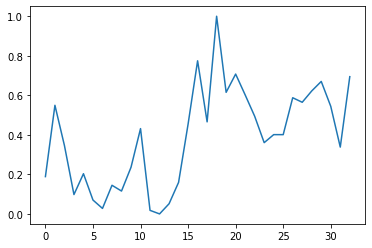

In [93]:
resid_norm.iloc[0].plot()

<AxesSubplot:>

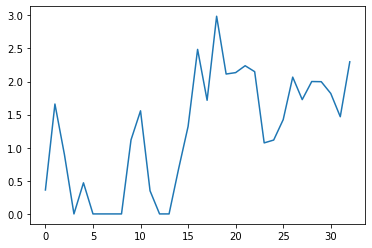

In [95]:
X.iloc[0].plot()

In [17]:
reload(cpb)

<module 'change_point_and_behavior' from '/mnt/home/szheng/projects/nmf_analysis/change_point_and_behavior.py'>

In [18]:
%%time
resid_res = cpb.regress_out_speed_get_residual_wrapper(data_dir_full,dosave=True,force_reload=False,load_only=False,
                                            speed_thresh=1,speed_key='v',
                                            save_fn='place_field_res_speed_residual.p'
                                                )

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_avg_and_trial_vthresh.p exists; loading---
saved at /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/place_field_res_speed_residual.p
CPU times: user 1min 44s, sys: 1.56 s, total: 1min 46s
Wall time: 1min 44s


In [23]:
resid_res['avg']['params'][0,0].loc['fr_mean']

0         1         2         3         4         5         6   \
3   0  0.188739  0.549517  0.345796  0.097913  0.203381  0.070173  0.027796   
27  0  0.013579  0.000000  0.461278  0.389077  0.550122  0.172308  0.611336   
29  0  0.330685  0.457325  0.609031  0.525087  0.356714  0.852570  0.508130   
    1  0.202999  0.068352  0.709849  0.669781  0.000000  0.377863  0.269418   
    2  0.000000  0.894116  0.567951  0.393046  0.418053  0.243156  0.322018   
...         ...       ...       ...       ...       ...       ...       ...   
463 1  0.752390  0.292965  0.635578  0.052594  0.564498  0.405877  0.202285   
465 0  0.065682  0.301085  0.041728  0.165826  0.052944  0.115746  0.353817   
475 0  1.000000  0.595987  0.502986  0.487252  0.402782  0.446945  0.460137   
476 0  1.000000  0.349767  0.187715  0.247811  0.160208  0.522623  0.405989   
480 0  0.418079  0.676067  0.223948  0.537433  0.247263  0.595737  0.254865   

             7         8         9   ...        23        24        25  \
3   0  0.144860  0.115708  0.236073  ...  0.360528  0.401058  0.401002   
27  0  0.282159  0.124556  0.139729  ...  0.255522  0.594979  0.446314   
29  0  0.573323  0.653588  0.468947  ...  0.338677  0.106111  0.158212   
    1  0.399484  0.444996  0.368674  ...  0.798425  0.753538  0.865548   
    2  0.116818  0.215522  0.716763  ...  0.735544  0.667006  0.561408   
...         ...       ...       ...  ...       ...       ...       ...   
463 1  0.076135  0.381025  0.180309  ...  0.090045  0.076239  0.667174   
465 0  0.070516  0.348441  0.131842  ...  0.216918  0.025209  0.094985   
475 0  0.168825  0.235508  0.456311  ...  0.301447  0.109682  0.314854   
476 0  0.133016  0.179532  0.435218  ...  0.058110  0.030844  0.102496   
480 0  0.309231  0.181610  0.506237  ...  0.487826  0.870127  1.000000   

             26        27        28        29        30        31        32  
3   0  0.587718  0.564772  0.622070  0.670229  0.544205  0.338081  0.694266  
27  0  0.571795  0.166898  0.456269  1.000000  0.322621  0.288923  0.332582  
29  0  0.180225  0.320179  0.081888  0.000000  0.305283  0.129788  0.080096  
    1  0.672025  0.742269  0.345305  0.645890  0.363519  0.360757  0.527703  
    2  0.788403  0.560439  0.208520  0.206606  0.396283  0.191688  0.165293  
...         ...       ...       ...       ...       ...       ...       ...  
463 1  0.129794  0.249487  0.162042  0.444009  0.000493  0.138191  0.889220  
465 0  0.057339  0.235440  0.052322  0.120841  0.061861  0.377133  0.042306  
475 0  0.179678  0.103967  0.258983  0.174757  0.164083  0.282938  0.223715  
476 0  0.096113  0.051899  0.068979  0.031431  0.093817  0.150935  0.091315  
480 0  0.252212  0.592052  0.205394  0.878470  0.577879  0.900349  0.741267  

[386 rows x 33 columns]